# Impact of Parameters Estimation to Portfolio Risk and Performance
by Chee-Foong on 10 Dec 2020

## Summary
Purpose of this analysis is to study how parameter estimation will affect the risk and performance of portfolio under different weighting schemes when come to asset allocation.  

Most asset allocation weighting schemes rely on security expected returns and covariance estimation.  Slight changes to these estimations may have significant impact to the weights in asset allocation and hence the portfolio performance.  Portfolio managers and analysts estimate these parameters differently based on data availability,  investment horizon and rebalancing frequency.

Expected returns and covariance estimation considerations:
1. Return horizon - eg: Yearly, Monthly, Weekly, Daily?
2. Return period - eg: 10, 5, 3, 2, 1 years?
3. Covariance on Sample Returns - Depending on return horizon?
4. Covariance on Sample Returns assuming constant correlation
5. Covariance with Statistical Shrinkage

Things to notes:
1. Selecting return periods depend on price history.  Depending on investment horizon, historical data that are too old may be a good reflection of current market conditions.  On the other hand, too short a history may not have enough data points to produce a good estimation of the parameters.
2. Select return horizon depends a lot on rebalance strategy and investment horizon.  Too short a horizon will may generate data points that are too noisy.  At the same time, it will mean more frequent rebalancing and hence higher transaction cost which is not taken into consideration in this analysis.


## Asset Allocation Weighting Schemes
Weighting schemes explored in this analysis:
1. MSR: Maximum Sharpe Ratio
2. GMV: Global Minimum Volatility
3. EW: Equally Weighted
4. ERC: Equal Risk Contribution (Risk Parity)

## Data
Price data are downloaded from yahoo finance.  Monthly returns are calculated and then used to estimate the asset expected returns and covariance matrix.

## Assets
Three funds are selected for this analysis:
- International High Yield Bonds ETF
- Real Estate ETF
- Total Bond Market ETF
- S&P 500 Trust ETF
- QQQ ETF
- DJIA ETF

Risk Free Rate: CBOE Interest Rate 10 Year T Note

## Backtesting 
Portfolio is rebalanced at the end of each month using past 36 months of returns.  The portfolio returns for the forward months are calculated and cumulative returns plotted for performance comparison.

----

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

import sys  
sys.path.append('../src') 
from edge_risk_kit import *

import edge_risk_kit as erk

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

DATA_FOLDER = '../data/'

---
## Importing Data from Yahoo Finance
Tickers:  

- IHY - VanEck Vectors International High Yield Bond ETF
- VNQ - Vanguard Real Estate ETF
- BND - Vanguard Total Bond Market ETF
- SPY - SPDR S&P 500
- QQQ - Invesco QQQ Trust, Series 1
- DIA - SPDR Dow Jones Industrial Average
- ^TNX - CBOE Interest Rate 10 Year T Note (Risk Free Rate)


Date Range:  
1 Jan 2000 to 31 Dec 2020

In [3]:
tickers = ['IHY','VNQ','BND','SPY','QQQ','DIA','^TNX']

start_date = '2000-01-01'
end_date = '2020-12-31'

In [4]:
import yfinance as yf

tickerlist = {}
for ticker in tickers:
    tickerlist[ticker] = yf.Ticker(ticker).info['shortName']
    
data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  7 of 7 completed


In [5]:
prices = data['Adj Close'][tickers].dropna()

In [6]:
tickerlist

{'IHY': 'VanEck Vectors International Hi',
 'VNQ': 'Vanguard Real Estate ETF',
 'BND': 'Vanguard Total Bond Market ETF',
 'SPY': 'SPDR S&P 500',
 'QQQ': 'Invesco QQQ Trust, Series 1',
 'DIA': 'SPDR Dow Jones Industrial Avera',
 '^TNX': 'CBOE Interest Rate 10 Year T No'}

In [7]:
namelist = tickerlist
namelist['IHY'] = 'International High Yield Bonds ETF'
namelist['VNQ'] = 'Real Estate ETF'
namelist['BND'] = 'Total Bond Market ETF'
namelist['SPY'] = 'S&P 500 Trust ETF'
namelist['QQQ'] = 'QQQ ETF'
namelist['DIA'] = 'DJIA ETF'

---
## Risk Free Rate - 10 Year Treasury Yield

In [8]:
rfr = prices['^TNX']/100
print('Risk Free Rate: {:.3f}%'.format(rfr[-1]*100))

Risk Free Rate: 0.933%


In [9]:
rfr_weekly = rfr.resample('W').fillna('ffill')
rfr_weekly.index = rfr_weekly.index.to_period('W')

In [10]:
rfr_monthly = rfr.resample('M').fillna('ffill')
rfr_monthly.index = rfr_monthly.index.to_period('M')

## Fund Information

In [11]:
to_drop = ['^TNX']
px = prices.drop(to_drop, axis=1)
print('Number of funds: {}'.format(len(px.columns)))
px.columns = px.columns.map(namelist)

Number of funds: 6


## Fund Returns

In [12]:
def calcRetsCov(px, freq):
    px_freq = px.resample(freq).fillna('ffill')
    px_freq.index = px_freq.index.to_period(freq)

    rets = px_freq.pct_change().dropna()
    cov = rets.cov()
    return rets, cov

#### Weekly

In [13]:
rets_weekly, cov_weekly = calcRetsCov(px, 'W')

#### Monthly

In [14]:
rets_monthly, cov_monthly = calcRetsCov(px, 'M')

### Summary statistics of returns

Observe below statistics the differences in annualised returns and volatility estimation using weekly and monthly returns.  These differences will contribute to different weights allocated to MSR, GMV and ERC portfolios leading to differences in portfolio performance.  EW portfolio is not affected parameter estimation.  Difference in portfolio performance on EW portfolio is contributed by rebalancing frequency only.

#### Weekly

In [15]:
rfr_period = rfr_weekly
rets_period = rets_weekly
PERIODS_PER_YEAR = 52

erk.summary_stats(rets_period, riskfree_rate=rfr_period[-1], periods_per_year=PERIODS_PER_YEAR).sort_values('Sharpe Ratio', ascending=False) \
            .style.bar(color=['pink', 'lightgreen'], align='zero')

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
QQQ ETF,0.199789,0.173836,-0.498793,6.325832,0.037493,0.055753,1.085689,-0.272503
S&P 500 Trust ETF,0.139248,0.156433,-0.863581,12.751995,0.033646,0.052999,0.822962,-0.318290
DJIA ETF,0.125815,0.165109,-0.996733,15.974335,0.035137,0.055333,0.699099,-0.344722
Total Bond Market ETF,0.033292,0.040757,-0.538910,25.167212,0.006949,0.012861,0.582594,-0.065825
International High Yield Bonds ETF,0.055146,0.091709,-2.874424,36.738727,0.019539,0.029126,0.495049,-0.222218
Real Estate ETF,0.076182,0.212055,-0.417615,24.174064,0.037303,0.066591,0.312379,-0.395945


#### Monthly

In [16]:
rfr_period = rfr_monthly
rets_period = rets_monthly
PERIODS_PER_YEAR = 12

erk.summary_stats(rets_period, riskfree_rate=rfr_period[-1], periods_per_year=PERIODS_PER_YEAR).sort_values('Sharpe Ratio', ascending=False) \
            .style.bar(color=['pink', 'lightgreen'], align='zero')

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
QQQ ETF,0.202901,0.156372,-0.062698,3.280964,0.057924,0.077863,1.227403,-0.169677
S&P 500 Trust ETF,0.139942,0.133581,-0.439706,4.741778,0.054718,0.080985,0.969464,-0.194477
DJIA ETF,0.124960,0.137950,-0.494768,4.803239,0.058486,0.083549,0.831069,-0.226247
Total Bond Market ETF,0.032269,0.033137,0.059607,3.471450,0.012711,0.016868,0.686362,-0.040059
International High Yield Bonds ETF,0.056261,0.089868,-1.430026,9.860718,0.043482,0.055908,0.517762,-0.148612
Real Estate ETF,0.071648,0.154634,-0.715597,6.087532,0.072122,0.092199,0.399528,-0.250558


### Plotting the Efficient Frontier
- Yellow: Equally Weighted Portfolio
- Green: Maximum Sharpe Ratio Portfolio
- Blue: Global Minimum Volatility Portfolio
- Red: Equal Risk Contribution Portfolio

Do note that the efficient frontier below is plotted based on parameters estimation namely the expected return (er) and covariance matrix (cov).  Slight changes in estimation of these 2 parameters may have significant impact to the weights in asset allocation and hence the portfolio returns.

There are differences the risk and return of each portfolio when using weekly and monthly returns as parameter estimations.

Note that while MSR portfolio may provide the highest sharpe ratio, realistically, it is very difficult to achieve as  it relies on both parameters.  Hence, most portfolio managers go for the minimum GMV portfolio that depends on only one parameter.  Similarly, the ERC portfolio only need the covariance matrix estimation.  The EW portfolio is the most straight-forward.  No parameter estimation is required.

#### Weekly

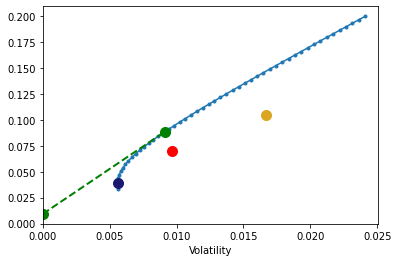

In [31]:
rfr_period = rfr_weekly
rets_period = rets_weekly
PERIODS_PER_YEAR=52

er = erk.annualize_rets(rets_period, periods_per_year=PERIODS_PER_YEAR)
cov = rets_period.cov()
erk.plot_ef(50, er, cov, riskfree_rate = rfr_period[-1], show_cml=True, show_ew=True, show_gmv=True, show_erc=True)
plt.show()

#### Monthly

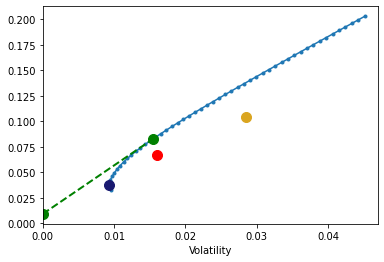

In [32]:
rfr_period = rfr_monthly
rets_period = rets_monthly
PERIODS_PER_YEAR=12

er = erk.annualize_rets(rets_period, periods_per_year=PERIODS_PER_YEAR)
cov = rets_period.cov()
erk.plot_ef(50, er, cov, riskfree_rate = rfr_period[-1], show_cml=True, show_ew=True, show_gmv=True, show_erc=True)
plt.show()

----
## Backtesting of Weighting Schemes and Parameter Estimations

#### Weekly Returns
- Parameter Estimations using past 3 years of historical returns
- Weighting schemes: 
    1. Equally Weighted (EWR)
    2. Global Minimum Volatility (GMV)
    3. Equal Risk Contribution (ERC)
    4. Maximum Sharpe Ratio (MSR)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.104011,0.137069,-0.980022,19.609303,0.027709,0.045872,0.684482,-0.269070
GMV,0.037478,0.045709,-2.632041,51.411782,0.007409,0.014006,0.610217,-0.090646
ERC,0.069063,0.080862,-1.091332,30.699894,0.014030,0.024391,0.732011,-0.165218
MSR,0.058612,0.105750,-1.027576,7.783433,0.025450,0.041217,0.461793,-0.138504


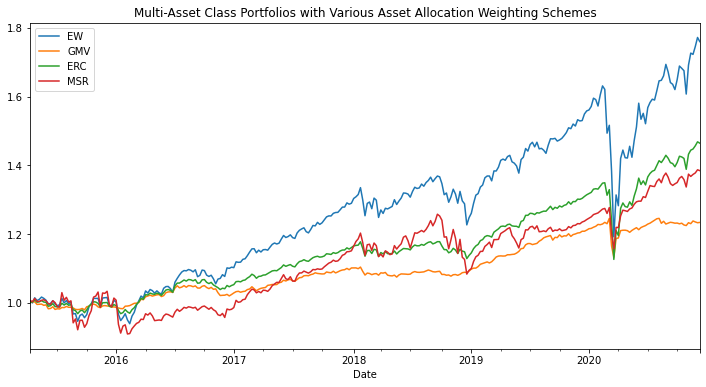

In [33]:
rfr_period = rfr_weekly
rets_period = rets_weekly
PERIODS_PER_YEAR = 52   ## 52 weeks per year
ESTIMATION_WINDOW = 156 ## 3 years historical data

ewr = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=erk.weight_ew)
gmv = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=erk.weight_gmv, 
                      cov_estimator=erk.sample_cov)
erc = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=erk.weight_erc, 
                      cov_estimator=erk.sample_cov)
msr = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=erk.weight_msr, 
                      cov_estimator=erk.sample_cov,
                      periods_per_year=PERIODS_PER_YEAR, rfr_series=rfr_period)

btr = pd.DataFrame({"EW": ewr, "GMV": gmv, "ERC": erc, "MSR": msr})
btr.dropna(inplace=True)
(1+btr).cumprod().plot(figsize=(12,6), title="Multi-Asset Class Portfolios with Various Asset Allocation Weighting Schemes")
erk.summary_stats(btr.dropna(), riskfree_rate=rfr_period[-1], periods_per_year=PERIODS_PER_YEAR)

#### Monthly Returns
- Parameter Estimations using past 3 years of historical returns
- Weighting schemes: 
    1. Equally Weighted (EWR)
    2. Global Minimum Volatility (GMV)
    3. Equal Risk Contribution (ERC)
    4. Maximum Sharpe Ratio (MSR)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.102847,0.111246,-0.532372,5.473395,0.046794,0.065153,0.833490,-0.158006
GMV,0.040602,0.038345,-1.160037,8.161396,0.016891,0.023226,0.808613,-0.046663
ERC,0.067538,0.063992,-0.579259,6.170529,0.026262,0.035995,0.901892,-0.083897
MSR,0.065523,0.108954,-0.502477,4.714346,0.048790,0.072073,0.511341,-0.127386


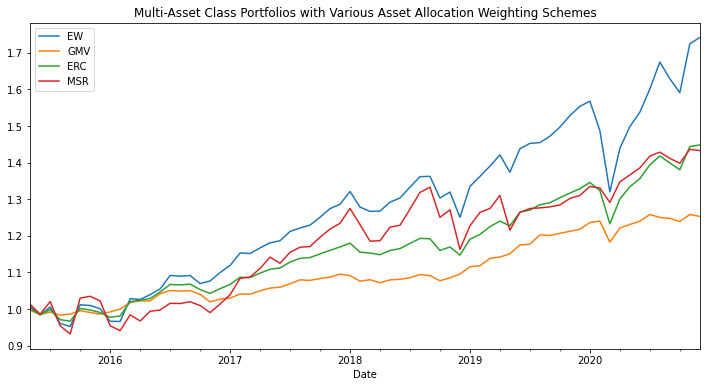

In [34]:
rfr_period = rfr_monthly
rets_period = rets_monthly
PERIODS_PER_YEAR = 12   ## 52 weeks per year
ESTIMATION_WINDOW = 36 ## 3 years historical data

ewr = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=erk.weight_ew)
gmv = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=erk.weight_gmv, 
                      cov_estimator=erk.sample_cov)
erc = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=erk.weight_erc, 
                      cov_estimator=erk.sample_cov)
msr = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=erk.weight_msr, 
                      cov_estimator=erk.sample_cov,
                      periods_per_year=PERIODS_PER_YEAR, rfr_series=rfr_period)

btr = pd.DataFrame({"EW": ewr, "GMV": gmv, "ERC": erc, "MSR": msr})
btr.dropna(inplace=True)
(1+btr).cumprod().plot(figsize=(12,6), title="Multi-Asset Class Portfolios with Various Asset Allocation Weighting Schemes")
erk.summary_stats(btr.dropna(), riskfree_rate=rfr_period[-1], periods_per_year=PERIODS_PER_YEAR)

### Observations

1. Sharpe Ratios are significantly higher when using monthly returns than weekly returns.  With more transaction cost expected for weekly rebalancing, one can expect the sharpe ratios to be worse off than those shown above.  In this scenario, using weekly returns as parameter estimations does not seems to be a good choice.
2. While EW portfolio generated the highest annualised return, it is the ERC portfolio that generated the best sharpe ratio.  Note that the ERC portfolio has a maximum drawdown of 8% as compared to the 15% by the EW portfolio.
3. MSR portfolio performs worst.  It is highly possible that rebalancing the MSR portfolio requires both the expected return and covariance parameters, creating more uncertainty.

## Can we improve the Sharpe Ratio with other covariance matrix estimation?

Possible covariance matrix estimate:
1. Standard Sample Convariance
2. Constant Correlation
3. Statistical Shrinkage

#### Constant Correlation

This idea is to take the sample correlation matrix, compute the average correlation and then reconstruct the covariance matrix. The relation between correlations $\rho$ and covariance $\sigma$ is given by:

$$ \rho_{ij} = \frac{ \sigma_{ij} } { \sqrt{ \sigma_{ii}  \sigma_{jj} } } $$


#### Statistical Shrinkage

We can mix the model and sample estimates by choosing a shrinkage parameter. One can either let the numbers dictate an optimal shrinkage value for $\delta$ although in practice many practiotioners choose $0.5$.  Let's implement a simple shrinkage based covariance estimator that shrinks towards the Constant Correlation estimate.

#### Special Note
- *We will just be using monthly returns for this analysis because weekly returns estimates did not seem to generate good portfolio sharpe ratios.*
- *We will also not be using the MSR portfolio weighting scheme given that it performs poorly as compared to the rest.*

In [35]:
def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    ccov = ccor * np.outer(sd, sd)
    return pd.DataFrame(ccov, index=r.columns, columns=r.columns)

In [36]:
def shrinkage_cov(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    prior = cc_cov(r, **kwargs)
    sample = erk.sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample

#### Monthly Returns
- Parameter Estimations using past 3 years of historical returns
- Weighting schemes: 
    1. Equally Weighted (EWR)
    2. Global Minimum Volatility (GMV)
    3. Equal Risk Contribution (ERC)
- Shrinkage Delta = 0.5 (0 being 100% sample correlation, 1 being 100% constant correlation)

In [37]:
rets_period = rets_monthly
rfr_period = rfr_monthly
PERIODS_PER_YEAR=12
ESTIMATION_WINDOW=36
DELTA=0.5

Summary of asset allocation of different weighting schemes.  Instinctively, the GMV portfolios has the largest allocation in Total Bond Market ETF.

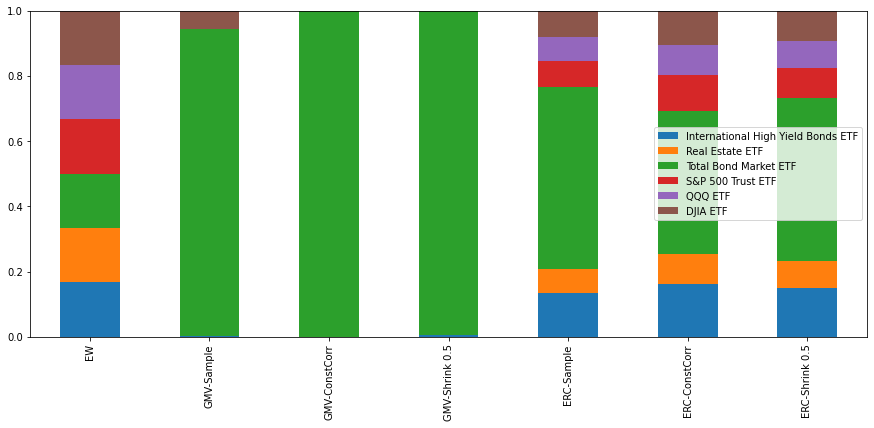

In [38]:
wts = pd.DataFrame({
    "EW": erk.weight_ew(rets_period),
    "GMV-Sample": weight_gmv(rets_period, cov_estimator=erk.sample_cov),
    "GMV-ConstCorr": weight_gmv(rets_period, cov_estimator=cc_cov),
    "GMV-Shrink 0.5": weight_gmv(rets_period, cov_estimator=shrinkage_cov),
    "ERC-Sample": weight_erc(rets_period, cov_estimator=erk.sample_cov),
    "ERC-ConstCorr": weight_erc(rets_period, cov_estimator=cc_cov),
    "ERC-Shrink 0.5": weight_erc(rets_period, cov_estimator=shrinkage_cov),
})
wts.T.plot.bar(stacked=True, figsize=(15,6), legend=True);


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.102847,0.111246,-0.532372,5.473395,0.046794,0.065153,0.833490,-0.158006
GMV-Sample,0.040602,0.038345,-1.160037,8.161396,0.016891,0.023226,0.808613,-0.046663
GMV-CC,0.032727,0.036354,-0.831370,5.943320,0.016101,0.021827,0.638127,-0.038863
GMV-Shrink 0.5,0.034705,0.037632,-1.300145,8.050198,0.017375,0.023450,0.668559,-0.046211
ERC-Sample,0.067538,0.063992,-0.579259,6.170529,0.026262,0.035995,0.901892,-0.083897
ERC-CC,0.076527,0.077927,-0.763385,6.856533,0.033177,0.044742,0.854992,-0.113077
ERC-Shrink 0.5,0.071712,0.070534,-0.677308,6.558847,0.029517,0.039840,0.876914,-0.097875


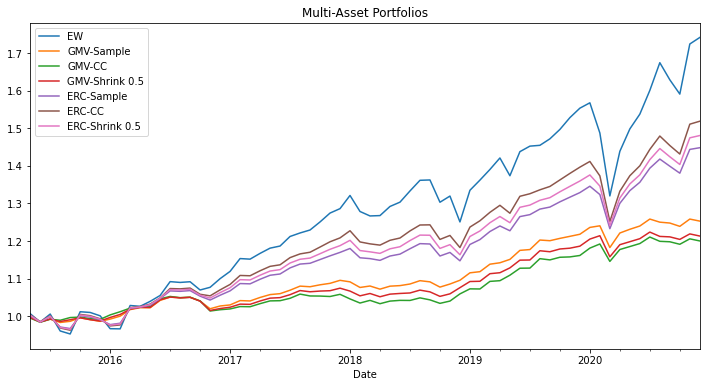

In [39]:
ewr = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=erk.weight_ew)
mv_s_r = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=weight_gmv, 
                         cov_estimator=erk.sample_cov)
mv_cc_r = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=weight_gmv, 
                          cov_estimator=cc_cov)
mv_sh_r = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=weight_gmv, 
                          cov_estimator=shrinkage_cov, 
                          delta=DELTA)
erc_s_r = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=weight_erc, 
                          cov_estimator=erk.sample_cov)
erc_cc_r = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=weight_erc, 
                           cov_estimator=cc_cov)
erc_sh_r = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=weight_erc, 
                           cov_estimator=shrinkage_cov, delta=DELTA)

btr = pd.DataFrame({"EW": ewr, 
                    "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r, 
                    'GMV-Shrink {}'.format(DELTA): mv_sh_r,
                    "ERC-Sample": erc_s_r, "ERC-CC": erc_cc_r, 
                    'ERC-Shrink {}'.format(DELTA): erc_sh_r})
btr.dropna(inplace=True)
(1+btr).cumprod().plot(figsize=(12,6), title="Multi-Asset Portfolios")
erk.summary_stats(btr.dropna(), riskfree_rate=rfr_period[-1], periods_per_year=PERIODS_PER_YEAR)

### Observations

1. Portfolios with weighting schemes on sample covariance still overperforms that with covariances of constant correlation and statistical shrinkage.  
2. GMV portfolios seem to perform poorly with covariances other than the sample covariance.

## Can we improve the Sharpe Ratio with Statistical Shrinkage between weekly and monthly returns?

In [40]:
def shrinkage_cov_v2(r, px, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the weekly and monthly sample covariance
    """
    start = str(r.index[0])
    end = str(r.index[-1])

    monthly = erk.sample_cov(r, **kwargs)
    _, weekly = calcRetsCov(px[start:end], 'W')
    
    return delta*weekly + (1-delta)*monthly

#### Monthly Returns
- Parameter Estimations using past 3 years of historical returns
- Weighting schemes: 
    1. Equally Weighted (EWR)
    2. Global Minimum Volatility (GMV)
    3. Equal Risk Contribution (ERC)
- Shrinkage Delta = 0.5 (0 being 100% sample correlation, 1 being 100% constant correlation)    
- Shrinkage v2 Delta = 0.5 (0 being 100% sample covariance using weekly returns, 1 being 100% sample covariance using monthly returns)

In [41]:
rets_period = rets_monthly
rfr_period = rfr_monthly
PERIODS_PER_YEAR=12
ESTIMATION_WINDOW=36
DELTA=0.5
DELTAv2=0.5

Summary of asset allocation of different weighting schemes.  

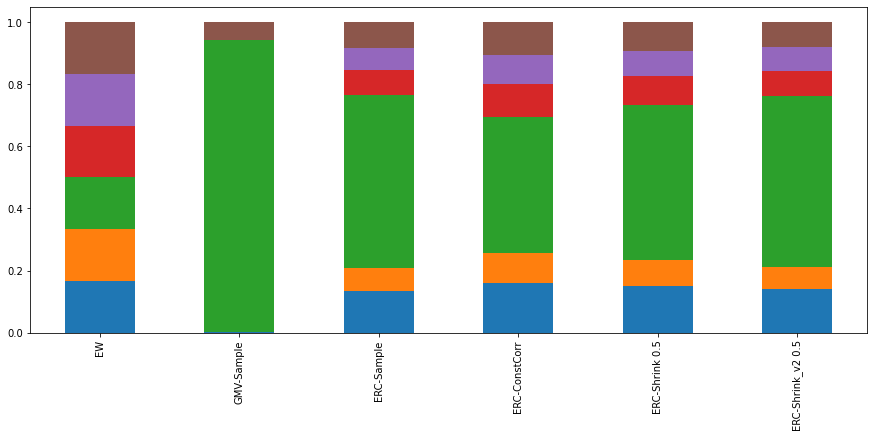

In [42]:
wts = pd.DataFrame({
    "EW": erk.weight_ew(rets_period),
    "GMV-Sample": weight_gmv(rets_period, cov_estimator=erk.sample_cov),
    "ERC-Sample": weight_erc(rets_period, cov_estimator=erk.sample_cov),
    "ERC-ConstCorr": weight_erc(rets_period, cov_estimator=cc_cov),
    "ERC-Shrink 0.5": weight_erc(rets_period, cov_estimator=shrinkage_cov, delta=DELTA),
    "ERC-Shrink_v2 0.5": weight_erc(rets_period, px=px, delta=DELTAv2,
                                    cov_estimator=shrinkage_cov_v2),
})
wts.T.plot.bar(stacked=True, figsize=(15,6), legend=False);

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.102847,0.111246,-0.532372,5.473395,0.046794,0.065153,0.833490,-0.158006
GMV-Sample,0.040602,0.038345,-1.160037,8.161396,0.016891,0.023226,0.808613,-0.046663
ERC-Sample,0.067538,0.063992,-0.579259,6.170529,0.026262,0.035995,0.901892,-0.083897
ERC-CC,0.076527,0.077927,-0.763385,6.856533,0.033177,0.044742,0.854992,-0.113077
ERC-Shrink 0.5,0.071712,0.070534,-0.677308,6.558847,0.029517,0.039840,0.876914,-0.097875
ERC-Shrink v2 0.5,0.068577,0.063985,-0.504549,6.202880,0.025804,0.035495,0.918089,-0.083074


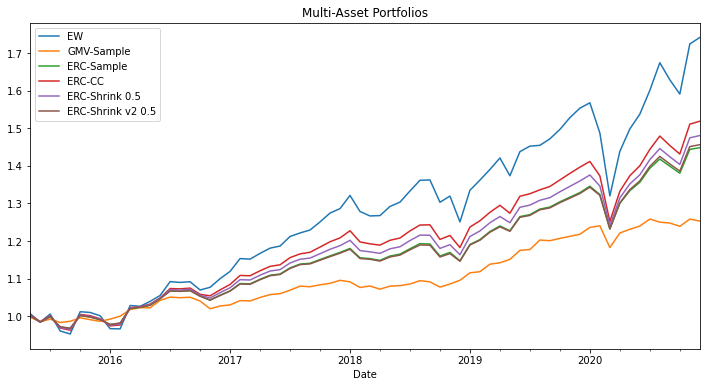

In [43]:
ewr = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=erk.weight_ew)
mv_s_r = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=weight_gmv, 
                         cov_estimator=erk.sample_cov)
erc_s_r = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=weight_erc, 
                          cov_estimator=erk.sample_cov)
erc_cc_r = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=weight_erc, 
                           cov_estimator=cc_cov)
erc_sh_r = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=weight_erc, 
                           cov_estimator=shrinkage_cov, delta=DELTA)
erc_sh_r_v2 = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=weight_erc, 
                          px=px, cov_estimator=shrinkage_cov_v2, 
                          delta=DELTAv2)

btr = pd.DataFrame({"EW": ewr, 
                    "GMV-Sample": mv_s_r, 
                    "ERC-Sample": erc_s_r, "ERC-CC": erc_cc_r, 
                    'ERC-Shrink {}'.format(DELTA): erc_sh_r, 'ERC-Shrink v2 {}'.format(DELTA): erc_sh_r_v2})
btr.dropna(inplace=True)
(1+btr).cumprod().plot(figsize=(12,6), title="Multi-Asset Portfolios")
erk.summary_stats(btr.dropna(), riskfree_rate=rfr_period[-1], periods_per_year=PERIODS_PER_YEAR)

### Observations

1. The Sharpe Ratio of the ERC portfolio with a new shrinkage based covariance estimator improved significantly.   It seems like a covariance estimated using weekly returns but with the ERC portfolio rebalanced on a monthly basis improves the performance.

### Testing the shrinkage delta to the extreme

- When Delta is 0, the covariance matrix is estimated using monthly returns
- When Delta is 1, the covariance matrix is estimated using weekly returns in the same estimation window
- When Delta is 0.5, the covariance matrix is the average of covariance matrix between the ones calculated using monthly returns and weekly returns

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.102847,0.111246,-0.532372,5.473395,0.046794,0.065153,0.833490,-0.158006
GMV-Sample,0.040602,0.038345,-1.160037,8.161396,0.016891,0.023226,0.808613,-0.046663
ERC-Sample,0.067538,0.063992,-0.579259,6.170529,0.026262,0.035995,0.901892,-0.083897
ERC-Shrink v2 0.0,0.067538,0.063992,-0.579259,6.170529,0.026262,0.035995,0.901892,-0.083897
ERC-Shrink v2 0.5,0.068577,0.063985,-0.504549,6.202880,0.025804,0.035495,0.918089,-0.083074
ERC-Shrink v2 1.0,0.059577,0.076508,-2.213312,16.160584,0.036931,0.046825,0.651175,-0.131398


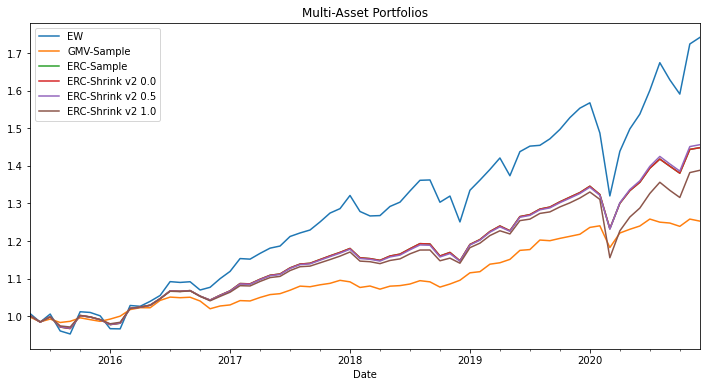

In [44]:
ewr = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=erk.weight_ew)
mv_s_r = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=weight_gmv, 
                         cov_estimator=erk.sample_cov)
erc_s_r = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=weight_erc, 
                          cov_estimator=erk.sample_cov)
erc_sh_r_v2_0 = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=weight_erc, 
                          px=px, cov_estimator=shrinkage_cov_v2, 
                          delta=0)
erc_sh_r_v2_5 = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=weight_erc, 
                          px=px, cov_estimator=shrinkage_cov_v2, 
                          delta=0.5)
erc_sh_r_v2_10 = erk.backtest_ws(rets_period, estimation_window=ESTIMATION_WINDOW, weighting=weight_erc, 
                          px=px, cov_estimator=shrinkage_cov_v2, 
                          delta=1)

btr = pd.DataFrame({"EW": ewr, 
                    "GMV-Sample": mv_s_r, 
                    "ERC-Sample": erc_s_r, 'ERC-Shrink v2 0.0': erc_sh_r_v2_0,
                    'ERC-Shrink v2 0.5': erc_sh_r_v2_5, 
                    'ERC-Shrink v2 1.0': erc_sh_r_v2_10})
btr.dropna(inplace=True)
(1+btr).cumprod().plot(figsize=(12,6), title="Multi-Asset Portfolios")
erk.summary_stats(btr.dropna(), riskfree_rate=rfr_period[-1], periods_per_year=PERIODS_PER_YEAR)

### Observations

1. The Sharpe Ratio of the ERC portfolio did not improve when delta is 1.  In fact, it performs poorly than the ERC portfolio with delta is 0.
2. The performance of the ERC portfolio with shrinkage delta of 0 matches that of ERC portfolio that uses covariance with sample correlation.  This is within expectation.
